# Imports

In [1]:
#Importar librerías necesarias para desarrollar el análisis
import importlib
import warnings

import pandas as pd
import numpy as np
import sklearn 
from sklearn.metrics import mean_squared_error, auc, log_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, make_scorer
import random as python_random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.stats import ks_2samp
import scorecardpy as sc
#import openpyxl

from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.feature_selection import SelectKBest, chi2, RFE, mutual_info_classif
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc, log_loss, roc_auc_score, accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, precision_score, make_scorer

from sklearn.model_selection import KFold, ShuffleSplit, LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 

from xgboost import XGBClassifier
from xgboost import XGBRegressor
import xgboost

import sys
import notebook
import jupyterlab

import os
from pathlib import Path

/Users/cristian/Documents/GitHub/adeslas-interview/.venv/lib/python3.13/site-packages/scorecardpy/germancredit.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from dotenv import load_dotenv, find_dotenv
# Carga el .env más cercano hacia arriba en el árbol
load_dotenv(find_dotenv())

# Raíz del proyecto = carpeta que contiene el .env
PROJECT_ROOT = Path(find_dotenv()).parent

# DATA_PATH puede ser relativo (./data) o absoluto; aquí lo resolvemos desde el root
DATA_PATH = (PROJECT_ROOT / os.environ.get("DATA_PATH", "data")).resolve()

In [3]:
import sys, platform
print(sys.executable)
print(platform.python_version())

/Users/cristian/Documents/GitHub/adeslas-interview/.venv/bin/python
3.13.7


In [4]:
pd.set_option("display.max_columns", None)   # muestra todas las columnas
pd.set_option("display.width", 0)            # usa el ancho de la celda de Jupyter
pd.set_option("display.max_colwidth", None)  # no truncar el contenido de celdas

# Env

In [5]:
PROJ_ROOT = Path.cwd().parent 
sys.path.insert(0, str(PROJ_ROOT / "src"))


# Verifica
print("Añadido a sys.path:", sys.path[0])

from utils import feature_selection as fs

Añadido a sys.path: /Users/cristian/Documents/GitHub/adeslas-interview/src


# Funciones

# Load data

In [6]:
DATA_PATH = Path(os.environ["DATA_PATH"])

In [7]:
file_tab = DATA_PATH / "df_muestra_vars_eng.csv"
df_muestra_vars_eng = pd.read_csv(file_tab)
print(df_muestra_vars_eng.shape)



file_tab = DATA_PATH / "X_train.csv"
X_train = pd.read_csv(file_tab)
print(X_train.shape)

file_tab = DATA_PATH / "X_val.csv"
X_val = pd.read_csv(file_tab)
print(X_val.shape)

file_tab = DATA_PATH / "X_test.csv"
X_test = pd.read_csv(file_tab)
print(X_test.shape)



file_tab = DATA_PATH / "y_train.csv"
y_train = pd.read_csv(file_tab)
print(len(y_train))


file_tab = DATA_PATH / "y_val.csv"
y_val = pd.read_csv(file_tab)
print(len(y_val))


file_tab = DATA_PATH / "y_test.csv"
y_test = pd.read_csv(file_tab)
print(len(y_test))


selected_vars = pd.read_csv(DATA_PATH / "selected_vars.csv")["feature"].astype(str).tolist()
print(len(selected_vars))

(47547, 420)
(28528, 418)
(9510, 418)
(9509, 418)
28528
9510
9509
20


# Model

## XGBoost con parametros estandar

In [8]:
# =========================
# Entrenamiento
# =========================
from utils.model_training import (
    train_xgb_binary,
    evaluate_model,
    save_artifacts,
    default_xgb_params,
)

# (Opcional) ajustar algunos hiperparámetros base
params = default_xgb_params() | dict(
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
)

results = train_xgb_binary(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    selected_vars=selected_vars,
    xgb_params=params,
    early_stopping_rounds=100,
)

print("Best iteration:", results.best_iteration)
print("n_estimators efectivos:", results.best_n_estimators)
display(results.metrics)



Best iteration: 2
n_estimators efectivos: 3


,auc,ks,prauc,n
split,,,,
train,0.816360,0.484141,0.160692,28528
val,0.674062,0.268752,0.093998,9510


In [9]:

# =========================
# Evaluación en Test
# =========================
from utils.model_training import to_1d_series

X_te = X_test[[c for c in selected_vars if c in X_test.columns]].copy()
y_te = to_1d_series(y_test)

eval_test = evaluate_model(results.model, splits={"test": (X_te, y_te)})
print("\nMétricas test:")
display(eval_test)




Métricas test:


,auc,ks,prauc,n
split,,,,
test,0.661152,0.234796,0.088275,9509


In [10]:
# =========================
# Guardado de artefactos
# =========================
#ARTIF_PATH = DATA_PATH / "models"
#model_path, feats_path = save_artifacts(results, ARTIF_PATH)
#print(f"Modelo guardado en: {model_path}")
#print(f"Features usadas guardadas en: {feats_path}")


# XGBoost con busqueda de HPO

In [11]:
from utils import model_training as mt
importlib.reload(mt)  # asegura cargar la última versión del módulo

<module 'utils.model_training' from '/Users/cristian/Documents/GitHub/adeslas-interview/src/utils/model_training.py'>

# Modelos new

## Preparacion de datos

In [12]:
# Alinear columnas con las seleccionadas
selected_vars = pd.read_csv(DATA_PATH / "selected_vars.csv")["feature"].astype(str)
use_cols = [c for c in selected_vars if c in X_train.columns]

X_tr, X_va, X_te = X_train[use_cols].copy(), X_val[use_cols].copy(), X_test[use_cols].copy()
y_tr = mt.to_1d_series(y_train)
y_va = mt.to_1d_series(y_val)
y_te = mt.to_1d_series(y_test)

# Desbalanceo (no lo usamos ahora, solo informativo)
pos = int(y_tr.sum()); neg = int(len(y_tr) - pos)
spw = max(1.0, neg / max(1, pos))
print(f"Class ratio -> pos={pos}, neg={neg}, scale_pos_weight≈{spw:.2f}")


Class ratio -> pos=571, neg=27957, scale_pos_weight≈48.96


In [13]:
splits={
    "train(refit)": (X_tr, y_tr),
    "val": (X_va, y_va),
    "test": (X_te, y_te),
}

for name, (_, y) in splits.items():
    tasa = y.mean()  # promedio = tasa de positivos
    print(f"{name}: tasa target = {tasa:.3%} ({y.sum()} de {len(y)})")


train(refit): tasa target = 2.002% (571 de 28528)
val: tasa target = 2.008% (191 de 9510)
test: tasa target = 1.998% (190 de 9509)


## Modelo 1 — Baseline (sin pesos, sin balanceo)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Baseline best params: {'colsample_bytree': np.float64(0.7542853455823514), 'gamma': np.float64(2.722699421778279), 'learning_rate': np.float64(0.021102634054601693), 'max_depth': 3, 'min_child_weight': 11, 'reg_alpha': np.float64(0.006490003020716538), 'reg_lambda': np.float64(30.731734742971184), 'subsample': np.float64(0.799432733244268)}


,auc,ks,prauc,n
split,,,,
test,0.695460,0.290985,0.121718,9509
train(refit),0.801388,0.441895,0.175221,28528
val,0.677368,0.261408,0.120014,9510


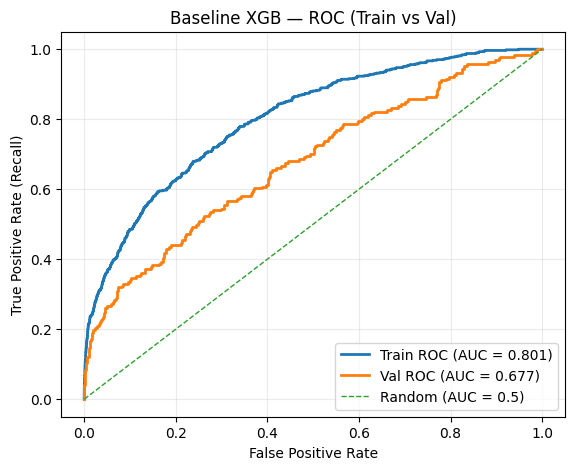

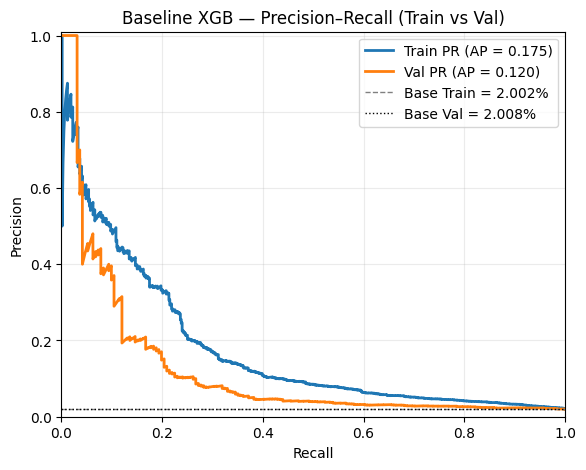

{'auc_train': 0.8013881964214871,
 'auc_val': 0.6773680298483815,
 'auc_gap': 0.12402016657310555,
 'prauc_train': 0.17522081860848776,
 'prauc_val': 0.12001417441289611,
 'prauc_gap': 0.05520664419559165,
 'prev_train': 0.020015423443634325,
 'prev_val': 0.020084121976866456}

In [19]:
rs_base = mt.randomized_search_xgb(
    X=X_tr, y=y_tr,
    base_params={},          # sin scale_pos_weight
    n_iter=40, 
    cv_splits=5,
    scoring="average_precision"
)
base_model = rs_base.best_estimator_
print("Baseline best params:", rs_base.best_params_)

res_base = mt.evaluate_model(
    base_model,
    splits={
        "train(refit)": (X_tr, y_tr),
        "val": (X_va, y_va),
        "test": (X_te, y_te),
    }
)
display(res_base)

metrics_gap = mt.plot_curves_train_val(
    model=base_model,
    X_train=X_tr, y_train=y_tr,
    X_val=X_va,   y_val=y_va,
    title_prefix="Baseline XGB",
    show=True
)
metrics_gap


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Baseline best params: {'colsample_bytree': np.float64(0.7542853455823514), 'gamma': np.float64(2.722699421778279), 'learning_rate': np.float64(0.021102634054601693), 'max_depth': 3, 'min_child_weight': 11, 'reg_alpha': np.float64(0.006490003020716538), 'reg_lambda': np.float64(30.731734742971184), 'subsample': np.float64(0.799432733244268)}


,auc,ks,prauc,n
split,,,,
test,0.695460,0.290985,0.121718,9509
train(refit),0.801388,0.441895,0.175221,28528
val,0.677368,0.261408,0.120014,9510


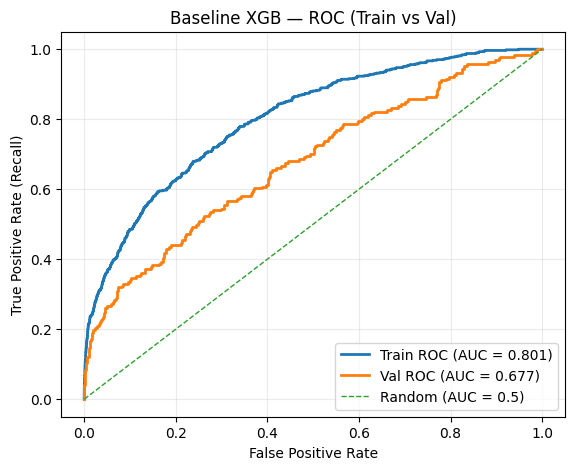

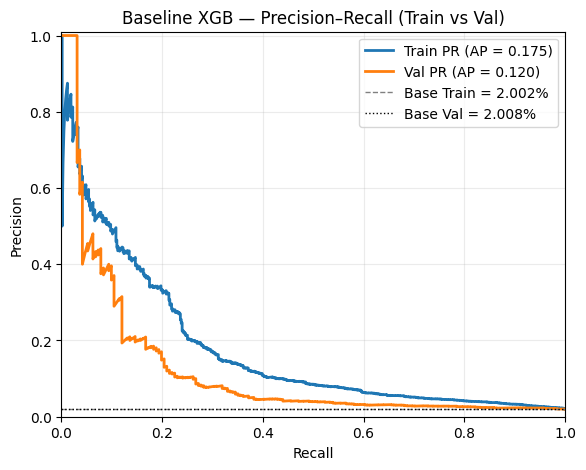

{'auc_train': 0.8013881964214871,
 'auc_val': 0.6773680298483815,
 'auc_gap': 0.12402016657310555,
 'prauc_train': 0.17522081860848776,
 'prauc_val': 0.12001417441289611,
 'prauc_gap': 0.05520664419559165,
 'prev_train': 0.020015423443634325,
 'prev_val': 0.020084121976866456}

In [20]:
# Buscamos hiperparámetros priorizando PR-AUC (típico en clase rara; suele correlacionar con mejor precision a altos umbrales)
rs_base = mt.randomized_search_xgb(
    X=X_tr, y=y_tr,
    base_params={},          # sin scale_pos_weight
    n_iter=80, cv_splits=5,
    scoring="average_precision"
)
base_model = rs_base.best_estimator_
print("Baseline best params:", rs_base.best_params_)

res_base = mt.evaluate_model(
    base_model,
    splits={
        "train(refit)": (X_tr, y_tr),
        "val": (X_va, y_va),
        "test": (X_te, y_te),
    }
)
display(res_base)

metrics_gap = mt.plot_curves_train_val(
    model=base_model,
    X_train=X_tr, y_train=y_tr,
    X_val=X_va,   y_val=y_va,
    title_prefix="Baseline XGB",
    show=True
)
metrics_gap


In [22]:
# ¿Cuántas combinaciones probó?
len(rs_base.cv_results_["params"]), rs_base.n_iter

(80, 80)

In [ ]:


# Top-5 combinaciones por score

cv = pd.DataFrame(rs_base.cv_results_)
cols = ["mean_test_score","std_test_score","rank_test_score","params"]
display(cv.sort_values("rank_test_score").head(5)[cols])


,mean_test_score,std_test_score,rank_test_score,params
14,0.133675,0.021301,1,"{'colsample_bytree': 0.7542853455823514, 'gamma': 2.722699421778279, 'learning_rate': 0.021102634054601693, 'max_depth': 3, 'min_child_weight': 11, 'reg_alpha': 0.006490003020716538, 'reg_lambda': 30.731734742971184, 'subsample': 0.799432733244268}"
27,0.133544,0.022555,2,"{'colsample_bytree': 0.923330571119153, 'gamma': 2.5689728756342776, 'learning_rate': 0.03359519814244161, 'max_depth': 3, 'min_child_weight': 8, 'reg_alpha': 2.5334585027005927, 'reg_lambda': 28.89919720738348, 'subsample': 0.8926703255569718}"
65,0.132789,0.022236,3,"{'colsample_bytree': 0.901054624513367, 'gamma': 2.9337020062628127, 'learning_rate': 0.05289069003052144, 'max_depth': 5, 'min_child_weight': 5, 'reg_alpha': 0.0014914308878983921, 'reg_lambda': 26.316488731000724, 'subsample': 0.9595578576393298}"
9,0.131517,0.022890,4,"{'colsample_bytree': 0.6481367528520412, 'gamma': 0.4958008171890075, 'learning_rate': 0.010479569306192631, 'max_depth': 3, 'min_child_weight': 8, 'reg_alpha': 0.03797747379173691, 'reg_lambda': 0.12178784754697529, 'subsample': 0.5070399113575422}"
56,0.130288,0.023574,5,"{'colsample_bytree': 0.6488175872546554, 'gamma': 0.29995466148559013, 'learning_rate': 0.01173778027238494, 'max_depth': 3, 'min_child_weight': 9, 'reg_alpha': 2.446654110322358, 'reg_lambda': 0.20548666982514602, 'subsample': 0.9784004425632282}"


## Modelo 2 — Balanceado por undersampling de la clase 0

In [23]:
# =========================
# Undersampling 50/50 en TRAIN
# =========================
from sklearn.utils import resample
import numpy as np
import pandas as pd

# Construyo un DF de trabajo con target
df_tr = X_tr.copy()
df_tr["target"] = y_tr

# Separo clases
df_pos = df_tr[df_tr["target"] == 1]
df_neg = df_tr[df_tr["target"] == 0]

n_pos = len(df_pos)
n_neg = len(df_neg)

if n_pos == 0:
    raise ValueError("No hay positivos en el set de entrenamiento.")
if n_neg == 0:
    raise ValueError("No hay negativos en el set de entrenamiento.")

# Undersample negativos hasta igualar a positivos (50/50)
df_neg_down = resample(
    df_neg,
    replace=False,
    n_samples=min(n_neg, n_pos),  # iguala a los positivos
    random_state=42,
)

# Conjunto balanceado 50/50
df_bal = pd.concat([df_pos, df_neg_down], axis=0).sample(frac=1.0, random_state=42)

X_tr_bal = df_bal.drop(columns="target")
y_tr_bal = df_bal["target"].astype(int)

print(
    f"Train original: pos={n_pos} ({n_pos/(n_pos+n_neg):.3%}), "
    f"neg={n_neg} ({n_neg/(n_pos+n_neg):.3%})"
)
print(
    f"Train balanceado: pos={int(y_tr_bal.sum())} "
    f"({y_tr_bal.mean():.3%}), neg={len(y_tr_bal)-int(y_tr_bal.sum())} "
    f"({1-y_tr_bal.mean():.3%})"
)


Train original: pos=571 (2.002%), neg=27957 (97.998%)
Train balanceado: pos=571 (50.000%), neg=571 (50.000%)


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Balanced(50/50) best params: {'colsample_bytree': np.float64(0.6373608964950321), 'gamma': np.float64(1.6837302775431033), 'learning_rate': np.float64(0.03149193527717024), 'max_depth': 5, 'min_child_weight': 3, 'reg_alpha': np.float64(1.1044350847124695), 'reg_lambda': np.float64(1.1916467090032163), 'subsample': np.float64(0.8854835899772805)}


,auc,ks,prauc,n
split,,,,
test,0.680715,0.280535,0.092507,9509
train(refit-50/50),0.928009,0.695271,0.927489,1142
val,0.659003,0.242971,0.090401,9510


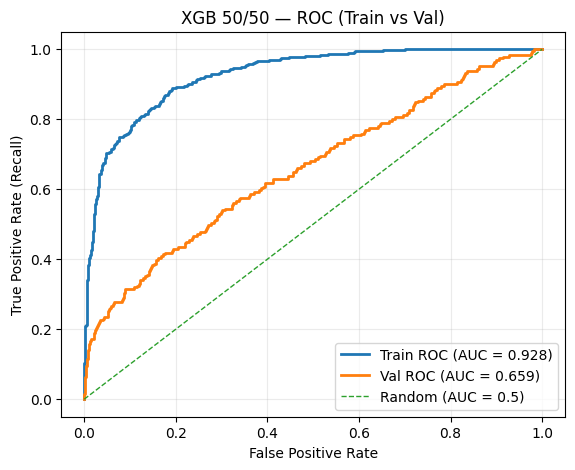

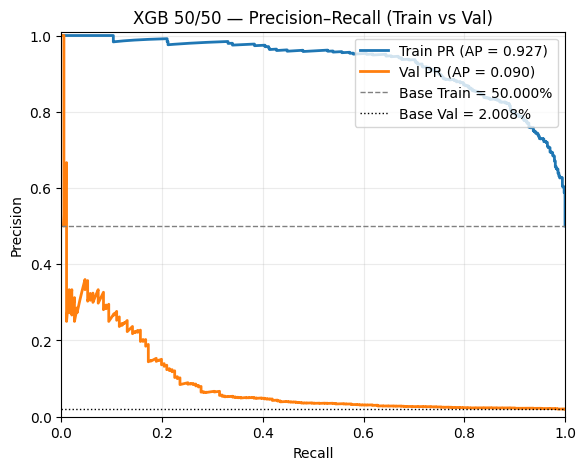

In [24]:
# =========================
# HPO en el set balanceado (PR-AUC)
# =========================
rs_bal50 = mt.randomized_search_xgb(
    X=X_tr_bal, y=y_tr_bal,
    base_params={},              # sin scale_pos_weight
    n_iter=40,                   # puedes subir a 80 si hay tiempo
    cv_splits=5,
    scoring="average_precision"
)
bal50_model = rs_bal50.best_estimator_
print("Balanced(50/50) best params:", rs_bal50.best_params_)

# =========================
# Evaluación en val/test (SIN balancear)
# =========================
res_bal50 = mt.evaluate_model(
    bal50_model,
    splits={
        "train(refit-50/50)": (X_tr_bal, y_tr_bal),
        "val": (X_va, y_va),
        "test": (X_te, y_te),
    }
)
display(res_bal50)


# =========================
# (Opcional) Curvas ROC/PR para ver overfitting del balanceado
# =========================
_ = mt.plot_curves_train_val(
    model=bal50_model,
    X_train=X_tr_bal, y_train=y_tr_bal,
    X_val=X_va,       y_val=y_va,
    title_prefix="XGB 50/50",
    show=True
)



## Model 3

In [25]:
anti_overfit_base = dict(
    max_depth=4,
    min_child_weight=10,
    gamma=2.0,
    reg_lambda=10.0,
    reg_alpha=1.0,
    subsample=0.7,
    colsample_bytree=0.7,
    learning_rate=0.03,  # si usas train_xgb_binary con early stopping
)

anti_overfit_space = {
    # congelo max_depth/subsample/colsample_bytree con base_params (no los incluyo aquí)
    "learning_rate": loguniform(0.01, 0.06),
    "min_child_weight": randint(8, 16),
    "gamma": uniform(1.0, 2.0),         # explora alrededor de 2.0
    "reg_alpha": loguniform(1e-2, 3.0),
    "reg_lambda": loguniform(5.0, 30.0),
}

# Con RandomizedSearchCV (sin early stopping), fija esto como base_params
rs_less_overfit = mt.randomized_search_xgb(
    X=X_tr, y=y_tr,
    base_params=anti_overfit_base,        # fija ancla
    param_distributions=anti_overfit_space,  # explora solo lo permitido
    n_iter=40, cv_splits=5,
    scoring="average_precision",
)


less_overfit_model = rs_less_overfit.best_estimator_
display(mt.evaluate_model(less_overfit_model, {"train(refit)": (X_tr, y_tr), "val": (X_va, y_va)}))


NameError: name 'loguniform' is not defined

## Evaluación comparativa (AUC / KS / PR-AUC)

In [ ]:
def eval_all(models: dict[str, object]) -> pd.DataFrame:
    rows = []
    for name, model in models.items():
        res = mt.evaluate_model(model, splits={"val": (X_va, y_va)}).reset_index()
        res["model"] = name
        rows.append(res)
    out = pd.concat(rows, ignore_index=True)
    return out.pivot(index="model", columns="split", values=["auc","ks","prauc"])

models = {
    "baseline": base_model,
     "spw": spw_model,        # descomenta si lo entrenas
    "balanced": bal_model,
}
display(eval_all(models))


## Elegir umbral para mejorar precision
- Política A: mínimo de precisión (p.ej., ≥30%) y luego maximizamos F₂ (para no matar del todo el recall).
- Política B: por presupuesto (top-k por score) + precisión mínima.
  
Qué mirar: para “incrementar la precisión”, elige el umbral (o top-k%) que logre la precision mínima deseada con un coste aceptable. Luego reporta el recall resultante (trade-off).

In [ ]:
# Probabilidades en validación
p_base = base_model.predict_proba(X_va)[:, 1]
p_bal  = bal_model.predict_proba(X_va)[:, 1]
# p_spw = spw_model.predict_proba(X_va)[:, 1]  # si entrenas el SPW

# A) Umbral con restricciones (min_precision + presupuesto) — aplicamos a cada modelo
def pick_thresholds_for_precision(p, name, min_precision=0.30, budget=50_000.0, unit_cost=50.0):
    rep = mt.select_threshold_with_constraints(
        y_true=y_va, y_proba=p,
        unit_cost=unit_cost, total_budget=budget,
        min_precision=min_precision, beta=2.0
    )
    print(f"[{name}] threshold (constraints):", None if rep is None else vars(rep))
    return rep

thr_base = pick_thresholds_for_precision(p_base, "baseline", min_precision=0.30, budget=50_000, unit_cost=50)
thr_bal  = pick_thresholds_for_precision(p_bal,  "balanced", min_precision=0.30, budget=50_000, unit_cost=50)
# thr_spw = pick_thresholds_for_precision(p_spw, "spw", min_precision=0.30, budget=50_000, unit_cost=50)  # si aplicas

# B) Escenarios top-k% para ver trade-off de precision/recall/coste
plans_base = mt.incentive_plans(p_base, y_va, unit_cost=50.0, topk_percents=(0.05,0.1,0.2,0.3), thresholds=[0.5,0.6,0.7], beta=2.0)
plans_bal  = mt.incentive_plans(p_bal,  y_va, unit_cost=50.0, topk_percents=(0.05,0.1,0.2,0.3), thresholds=[0.5,0.6,0.7], beta=2.0)
print("Plans — Baseline");  display(plans_base)
print("Plans — Balanced");  display(plans_bal)


# Ensamble (promedio de probabilidades)
Dado el objetivo de subir precisión, el ensamble te da scores más estables. Luego subes el umbral para lograr la precision objetivo.

In [ ]:
# Puedes promediar 2 o 3 modelos (aquí baseline + balanced)
p_ens_val = (p_base + p_bal) / 2
# si entrenaste SPW: p_ens_val = (p_base + p_bal + p_spw) / 3

# Umbral del ensamble con restricciones (buscando mejorar precisión)
thr_ens = mt.select_threshold_with_constraints(
    y_true=y_va, y_proba=p_ens_val,
    unit_cost=50.0, total_budget=50_000.0,
    min_precision=0.30, beta=2.0
)
print("[ensemble] threshold (constraints):", None if thr_ens is None else vars(thr_ens))

# Métricas del ensamble con ese corte (en validación)
rep_ens_val = mt.threshold_metrics(y_true=y_va, y_proba=p_ens_val, threshold=thr_ens.threshold if thr_ens else 0.5, beta=2.0)
cost_ens_val = rep_ens_val.positives_pred * 50.0
print("Ensemble @val:", {**vars(rep_ens_val), "coste": cost_ens_val})


# Evaluación final en test al corte elegido

In [ ]:
# Probabilidades en test de cada modelo
p_base_te = base_model.predict_proba(X_te)[:, 1]
p_bal_te  = bal_model.predict_proba(X_te)[:, 1]
# p_spw_te  = spw_model.predict_proba(X_te)[:, 1]  # si aplicas

p_ens_te = (p_base_te + p_bal_te) / 2
# si entrenaste SPW: p_ens_te = (p_base_te + p_bal_te + p_spw_te) / 3

# Usa el threshold del ensamble (o del modelo preferido) obtenido en validación
thr = thr_ens.threshold if thr_ens is not None else 0.5
rep_test = mt.threshold_metrics(y_true=y_te, y_proba=p_ens_te, threshold=thr, beta=2.0)
cost_test = rep_test.positives_pred * 50.0

print("TEST — Ensemble @ chosen threshold:")
print({**vars(rep_test), "coste": cost_test})


# Write

In [ ]:
#import json, joblib
#ART = DATA_PATH / "models"; ART.mkdir(parents=True, exist_ok=True)

#joblib.dump(base_model, ART / "xgb_baseline_rs.joblib")
#joblib.dump(bal_model,  ART / "xgb_balanced_rs.joblib")
#pd.Series(use_cols, name="feature").to_csv(ART / "xgb_used_features_rs.csv", index=False)

#with open(ART / "baseline_best_params.json", "w") as f: json.dump(rs_base.best_params_, f, indent=2)
#with open(ART / "balanced_best_params.json", "w") as f: json.dump(rs_bal.best_params_, f, indent=2)

#decision = {"threshold": float(thr if thr_ens is None else thr_ens.threshold), "min_precision": 0.30, "unit_cost": 50.0}
#with open(ART / "decision_threshold.json", "w") as f: json.dump(decision, f, indent=2)


Mini-checklist para tu entrega

✅ Comparativa baseline vs balanced (tabla val).

✅ Umbral elegido con precision mínima y coste.

✅ Ensamble con métricas y coste.

✅ Top factores/interacciones (SHAP) para explicar perfiles de riesgo.

✅ Planes de campaña (top-k% y por presupuesto) con trade-offs.

Si luego quieres correr la versión con scale_pos_weight, descomenta el bloque del Modelo 2 y añade sus probabilidades al ensamble.